# Overview
The notebook shows how the ```lime_image``` tools can be applied to a slightly larger dataset like the Olivetti Faces. The dataset is very low resolution and allows quite a bit of rapid-iteration.

In [7]:
#!pip install lime

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import gray2rgb, rgb2gray # since the code wants color images
from skimage.util import montage as montage2d # to make a nice montage of the images

In [9]:
#prevent url error downloading dataset
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [10]:
from sklearn.datasets import fetch_olivetti_faces
faces = fetch_olivetti_faces()
# make each image color so lime_image works correctly
X_vec = np.stack([gray2rgb(iimg) for iimg in faces.data.reshape((-1, 64, 64))],0)
y_vec = faces.target.astype(np.uint8)

(-0.5, 1279.5, 1279.5, -0.5)

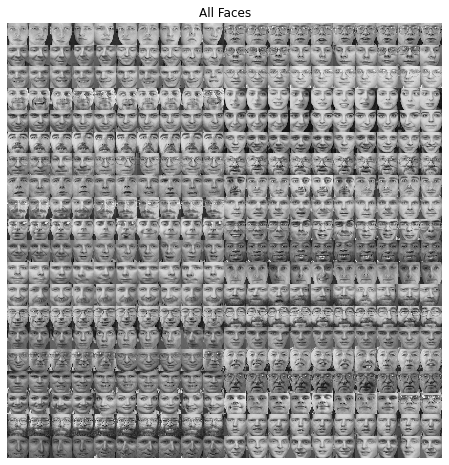

In [11]:
%matplotlib inline
fig, ax1 = plt.subplots(1,1, figsize = (8,8))
ax1.imshow(montage2d(X_vec[:,:,:,0]), cmap='gray', interpolation = 'none')
ax1.set_title('All Faces')
ax1.axis('off')

# Setup a Pipeline
Here we make a pipeline for processing the images where basically we flatten the image back to 1d vectors and then use a RandomForest Classifier

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import PCA

class PipeStep(object):
    """
    Wrapper for turning functions into pipeline transforms (no-fitting)
    """
    def __init__(self, step_func):
        self._step_func=step_func
    def fit(self,*args):
        return self
    def transform(self,X):
        return self._step_func(X)

makegray_step = PipeStep(lambda img_list: [rgb2gray(img) for img in img_list])
flatten_step = PipeStep(lambda img_list: [img.ravel() for img in img_list])

simple_rf_pipeline = Pipeline([
    ('Make Gray', makegray_step),
    ('Flatten Image', flatten_step),
    ('Normalize', Normalizer()),
    ('PCA', PCA(25)),
    ('XGBoost', GradientBoostingClassifier())
                              ])

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_vec, y_vec,
                                                    train_size=0.70)

In [14]:
simple_rf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('Make Gray', <__main__.PipeStep object at 0x7f3452650df0>),
                ('Flatten Image', <__main__.PipeStep object at 0x7f3452650e50>),
                ('Normalize', Normalizer()), ('PCA', PCA(n_components=25)),
                ('XGBoost', GradientBoostingClassifier())])

# Scoring the Model
We show the scoring of the model on the test data to see how well it works


In [15]:
# compute on remaining test data
pipe_pred_test = simple_rf_pipeline.predict(X_test)
pipe_pred_prop = simple_rf_pipeline.predict_proba(X_test)
from sklearn.metrics import classification_report
print(classification_report(y_true=y_test, y_pred = pipe_pred_test))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.50      0.33      0.40         3
           2       0.33      1.00      0.50         1
           3       0.50      1.00      0.67         1
           4       0.22      1.00      0.36         2
           5       1.00      0.67      0.80         3
           6       0.50      0.50      0.50         4
           7       0.33      0.33      0.33         3
           8       1.00      1.00      1.00         2
           9       0.00      0.00      0.00         5
          10       1.00      1.00      1.00         3
          11       0.50      1.00      0.67         1
          12       0.50      0.50      0.50         4
          13       1.00      0.67      0.80         3
          14       0.00      0.00      0.00         1
          15       1.00      0.75      0.86         4
          16       1.00      1.00      1.00         3
          17       0.50    

/opt/software/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/software/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/software/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [16]:
%load_ext autoreload
%autoreload 2
import os,sys
try:
    import lime
except:
    sys.path.append(os.path.join('..', '..')) # add the current directory
    import lime

In [21]:
from lime.wrappers.scikit_image import SegmentationAlgorithm
from lime import lime_image
explainer = lime_image.LimeImageExplainer(verbose = False)
segmenter = SegmentationAlgorithm('slic', n_segments=100, compactness=1, sigma=1)

In [22]:
%%time
explanation = explainer.explain_instance(X_test[0], 
                                         classifier_fn = simple_rf_pipeline.predict_proba, 
                                         top_labels=6, hide_color=0, num_samples=10000, segmentation_fn=segmenter)

  0%|          | 0/10000 [00:00<?, ?it/s]

CPU times: user 19.3 s, sys: 462 ms, total: 19.8 s
Wall time: 5 s


Text(0.5, 1.0, 'Positive/Negative Regions for 32')

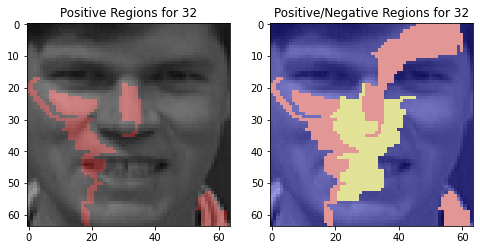

In [23]:
from skimage.color import label2rgb
temp, mask = explanation.get_image_and_mask(y_test[0], positive_only=True, num_features=5, hide_rest=False)
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (8, 4))
ax1.imshow(label2rgb(mask,temp, bg_label = 0), interpolation = 'nearest')
ax1.set_title('Positive Regions for {}'.format(y_test[0]))
temp, mask = explanation.get_image_and_mask(y_test[0], positive_only=False, num_features=10, hide_rest=False)
ax2.imshow(label2rgb(3-mask,temp, bg_label = 0), interpolation = 'nearest')
ax2.set_title('Positive/Negative Regions for {}'.format(y_test[0]))

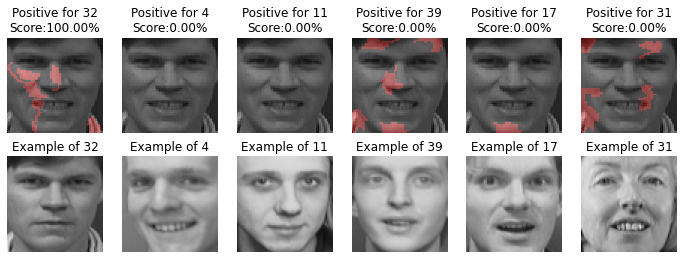

In [24]:
# now show them for each class
fig, m_axs = plt.subplots(2,6, figsize = (12,4))
for i, (c_ax, gt_ax) in zip(explanation.top_labels, m_axs.T):
    temp, mask = explanation.get_image_and_mask(i, positive_only=True, num_features=5, hide_rest=False, min_weight=0.01)
    c_ax.imshow(label2rgb(mask,temp, bg_label = 0), interpolation = 'nearest')
    c_ax.set_title('Positive for {}\nScore:{:2.2f}%'.format(i, 100*pipe_pred_prop[0, i]))
    c_ax.axis('off')
    face_id = np.random.choice(np.where(y_train==i)[0])
    gt_ax.imshow(X_train[face_id])
    gt_ax.set_title('Example of {}'.format(i))
    gt_ax.axis('off')

# Gaining Insight
Can we find an explanation for a classification the algorithm got wrong

In [25]:
wrong_idx = np.random.choice(np.where(pipe_pred_test!=y_test)[0])

print('Using #{} where the label was {} and the pipeline predicted {}'.format(wrong_idx, y_test[wrong_idx], pipe_pred_test[wrong_idx]))

Using #35 where the label was 9 and the pipeline predicted 20


In [26]:
%%time
explanation = explainer.explain_instance(X_test[wrong_idx], 
                                         classifier_fn = simple_rf_pipeline.predict_proba, 
                                         top_labels=6, hide_color=0, num_samples=10000, segmentation_fn=segmenter)

  0%|          | 0/10000 [00:00<?, ?it/s]

CPU times: user 19.6 s, sys: 532 ms, total: 20.1 s
Wall time: 5.11 s


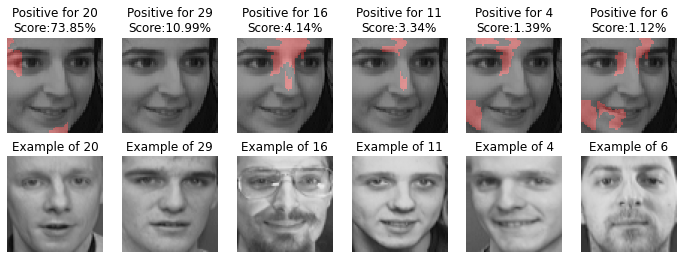

In [27]:
# now show them for each class
fig, m_axs = plt.subplots(2,6, figsize = (12,4))
for i, (c_ax, gt_ax) in zip(explanation.top_labels, m_axs.T):
    temp, mask = explanation.get_image_and_mask(i, positive_only=True, num_features=5, hide_rest=False, min_weight=0.01)
    c_ax.imshow(label2rgb(mask,temp, bg_label = 0), interpolation = 'nearest')
    c_ax.set_title('Positive for {}\nScore:{:2.2f}%'.format(i, 100*pipe_pred_prop[wrong_idx, i]))
    c_ax.axis('off')
    face_id = np.random.choice(np.where(y_train==i)[0])
    gt_ax.imshow(X_train[face_id])
    gt_ax.set_title('Example of {}'.format(i))
    gt_ax.axis('off')